In [25]:
import numpy as np
from collections import Counter

class Node:
    
    def __init__(self , feature=None , threshold = None , left_child = None , right_child = None , * ,value=None) -> None:
        self.feature = feature 
        self.threshold = threshold
        self.left_child = left_child
        self.right_child = right_child
        self.value = value
    
    def is_leaf_node(self):
        return True if self.value is not None else False

def entropy(y):
    class_count = np.bincount(y) # returns bincount over the range of (y_min , y_max)

    Px = class_count/len(y)
    entropy = -np.sum([p*np.log2(p) for p in Px if p > 0])

    return entropy

class DecisionTree:

    def __init__(self , n_features : int = None , max_depth : int = 10 ,min_sample_to_split : int = 2  ,verbose : bool = False) -> None:
        self.n_features = n_features
        self.max_depth = max_depth
        self.root = None
        self.min_sample_to_split = min_sample_to_split  # minimum sample to split a given group
        self.verbose = verbose

    def fit(self , X : np.ndarray , y : np.ndarray) -> None:
        n_samples , n_features = X.shape
        self.n_features = n_features if self.n_features is None else min(self.n_features , n_features)
        self.root = self._build_decision_tree(X,y)
    
    def predict(self , x_test : np.ndarray) -> np.ndarray:
        y_pred = [self._traverse_decision(x , self.root) for x in x_test]

        return np.array(y_pred)

    def _traverse_decision(self , x : np.ndarray , node : Node):
        
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_decision(x,node.left_child)
        else :
            return self._traverse_decision(x,node.right_child)


    def _build_decision_tree(self , X : np.ndarray , y : np.ndarray , depth : int = 0) -> Node:

        n_samples , n_feat = X.shape
        unique_class = np.unique(y)
        n_labels= len(unique_class)

        # make a leaf node if it satisfies following condition
        if (n_labels == 1 or depth >= self.max_depth or n_samples < self.min_sample_to_split ):

            label = self.__most_common_label(y)
            leaf_node = Node(value=label)
            return leaf_node
        
        features_idx = np.random.choice(n_feat, self.n_features  , replace=False) #random array of feature index
        
        best_information_gain = -1
        best_feature_split = None
        best_threshold_split = None
        
        for feature in features_idx:
            X_c = X[:,feature]
            thresholds = np.unique(X_c)  #get all the unique values in that feature

            for threshold in thresholds:
                ig = self._get_information_gain(X_c ,y , threshold)
                if ig > best_information_gain:
                    best_information_gain = ig
                    best_feature_split = feature
                    best_threshold_split = threshold

        left_idx , right_idx = self._split_on_threshold(X[: , best_feature_split] , best_threshold_split)
        
        root = Node(feature=best_feature_split , threshold=best_threshold_split)
        
        root.left_child = self._build_decision_tree(X[ left_idx , :] , y[left_idx] , depth+1)
        root.right_child = self._build_decision_tree(X[right_idx , :] , y[right_idx] , depth+1)

        return root

    def _get_information_gain(self ,X_c : np.ndarray ,y: np.ndarray , threshold):
        left_idx , right_idx = self._split_on_threshold(X_c , threshold)

        parent_entrophy = entropy(y)
        n_y = len(y) 
        n_left = len(left_idx)
        n_right = len(right_idx)
        entropy_left_split = entropy(y[left_idx])
        entropy_right_split = entropy(y[right_idx])

        child_entropy = ( (n_left/n_y)*entropy_left_split ) + ( (n_right/n_y)*entropy_right_split )

        return parent_entrophy - child_entropy


    def _split_on_threshold(self , X_c : np.ndarray , threshold):
        left_idx = np.argwhere(X_c <= threshold).flatten()
        right_idx = np.argwhere(X_c > threshold).flatten()

        return left_idx , right_idx

    def __most_common_label(self , samples):
        try:
            counter = Counter(samples)
            return counter.most_common(1)[0][0]
        except:
            return 0


In [26]:
class RandomForest:
    def __init__(self , n_tress : int = 10 , min_samples_split : int = 2 ,max_depth : int = 100, n_features = None) -> None:
        self.n_tress = n_tress
        self.n_features = n_features
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.trees = []


    def bootstrap(self , X : np.ndarray , y: np.ndarray):

        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples , size=n_samples , replace=True)

        return X[idxs] , y[idxs]

    def fit(self , X : np.ndarray , y : np.ndarray):
        for _ in range(self.n_tress):
            tree = DecisionTree(n_features=self.n_features , max_depth=self.max_depth , min_sample_to_split=self.min_samples_split)
            x_sample , y_sample = self.bootstrap(X , y)
            tree.fit(x_sample ,y_sample)
            self.trees.append(tree)

    def predict(self , x_test : np.ndarray):
        
        predictions = np.array([tree.predict(x_test) for tree in self.trees ])
        predictions = np.swapaxes(predictions , 0 ,1)
        y_pred = [self.__most_common_label(labels) for labels in predictions]
        return np.array(y_pred)

    def __most_common_label(self , samples):
        counter = Counter(samples)
        return counter.most_common(1)[0][0]

def accuracy(y_true : np.ndarray , y_pred : np.ndarray):
    acc = np.sum(y_true == y_pred)/y_pred.shape[0]
    return acc

              Age  EstimatedSalary   Purchased
count  400.000000       400.000000  400.000000
mean    37.655000     69742.500000    0.357500
std     10.482877     34096.960282    0.479864
min     18.000000     15000.000000    0.000000
25%     29.750000     43000.000000    0.000000
50%     37.000000     70000.000000    0.000000
75%     46.000000     88000.000000    1.000000
max     60.000000    150000.000000    1.000000


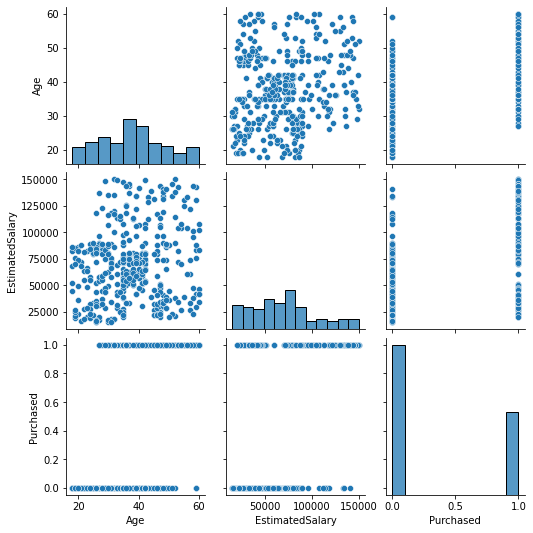

In [31]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
dataset = pd.read_csv('datasets/Social_Network_Ads.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

print(dataset.describe())

import seaborn as sns

sns.pairplot(dataset)

In [30]:

x_train , x_test , y_train , y_test = train_test_split(X , y , test_size=0.3)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

rf = RandomForest()

rf.fit(x_train , y_train)

y_pred  = rf.predict(x_test)

print(accuracy(y_test , y_pred))

0.9083333333333333


[+] CLASSIFICATION REPORT FOR RANDOM FOREST

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        74
           1       0.91      0.85      0.88        46

    accuracy                           0.91       120
   macro avg       0.91      0.90      0.90       120
weighted avg       0.91      0.91      0.91       120


[+] CONFUSION MATRIX
[[70  4]
 [ 7 39]]


<AxesSubplot:>

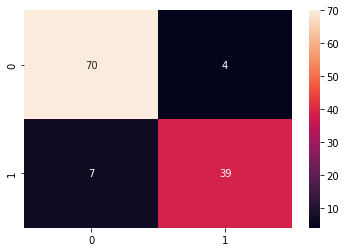

In [32]:
from sklearn.metrics import classification_report , confusion_matrix

print("[+] CLASSIFICATION REPORT FOR RANDOM FOREST\n")
print(classification_report(y_test,y_pred))

print("\n[+] CONFUSION MATRIX")
print(confusion_matrix(y_test , y_pred))

import seaborn as sns

sns.heatmap(confusion_matrix(y_test , y_pred) , annot=True)